In [1]:
import math
import time
import os.path as osp
from itertools import chain

import momepy
import fiona
import geopandas as gpd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn.functional as F
from scipy.sparse.csgraph import shortest_path
from sklearn.metrics import roc_auc_score
from torch.nn import BCEWithLogitsLoss, Conv1d, MaxPool1d, ModuleList

from torch_geometric.data import Data, Batch, InMemoryDataset, download_url, extract_zip
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, GCNConv, global_sort_pool
from torch_geometric.nn import GAE, VGAE
from torch_geometric.transforms import RandomLinkSplit, OneHotDegree
from torch_geometric.utils import k_hop_subgraph, to_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
project_root = '/homes/wwc4618/predicting-choice'
dataset_root = f'{project_root}/datasets'

/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
full_dataset_label = 'No Bounds'
training_places = ['London']

# Fields to ignore
meridian_fields = ['meridian_id', 'meridian_gid', 'meridian_code',
                   'meridian_osodr', 'meridian_number', 'meridian_road_name',
                   'meridian_indicator', 'meridian_class', 'meridian_class_scale']
census_geom_fields = ['wz11cd', 'lsoa11nm', 'msoa11nm',
                      'oa11cd', 'lsoa11cd', 'msoa11cd'] # Allowed: lad11cd, lad11nm
misc_fields = ['id']
ignore_fields = meridian_fields + census_geom_fields + misc_fields


unnorm_feature_fields = ['metres', 'choice2km', 'nodecount2km', 'integration2km',
                      'choice10km', 'nodecount10km','integration10km',
                      'choice100km','nodecount100km','integration100km']
rank_fields = ['choice2kmrank', 'choice10kmrank','integration10kmrank', 'integration2kmrank']
log_fields = ['choice2kmlog','choice10kmlog','choice100kmlog']
all_feature_fields = unnorm_feature_fields + rank_fields + log_fields

# Post-processing features
feats = ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km',
         'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km',
         'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank',
         'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']

# dictionary caches - RELOADING THIS CELL DELETES GRAPH CACHES
loaded_gdfs = {}
loaded_graphs={}

full_gdf = gpd.read_file(f'{project_root}/OpenMapping-gb-v1_gpkg/gpkg/ssx_openmapping_gb_v1.gpkg',
                    ignore_fields=ignore_fields)
included_places = full_gdf['lad11nm'].dropna().unique()
print(f'SSx metrics of {len(included_places)} local authorities retrieved') 
print(included_places)
osmnx_buffer = 10000

def load_gdf(place=training_places[0], verbose=False): #(W, S, E, N)
    """Geodataframe (gdf) loader with caching"""
    if place in included_places:
        # Retrieve matching rows corresponding to the Local Authority
        print(f'Loading {place} from SSx')
        gdf = full_gdf.query(f'lad11nm == "{place}"').copy()
    elif place == full_dataset_label:
        # Read full dataset without boundaries
        gdf = full_gdf.copy()
    else:
        print(f'Loading {place} from OSMnx')
        # Load gdf from osmnx (for testing only, graph will lack target attr)
        # Actually uses the Nominatim API:
        # https://nominatim.org/release-docs/latest/api/Overview/
        g = ox.graph.graph_from_place(place, buffer_dist=osmnx_buffer)
        g = ox.projection.project_graph(g)
        gdf = ox.utils_graph.graph_to_gdfs(g, nodes=False)
        gdf = gdf.rename(columns={'length': 'metres'})
        return gdf

    if verbose:
        print(f'{gdf.size} geometries retrieved from {place}')

    loaded_gdfs[place] = gdf
    return gdf

SSx metrics of 348 local authorities retrieved
['Isle of Wight' 'Wycombe' 'Enfield' 'Slough' 'South Bucks' 'Hillingdon'
 'Ealing' 'Chiltern' 'Copeland' 'Windsor and Maidenhead' 'Plymouth'
 'South Hams' 'Oxford' 'Waltham Forest' 'Mendip' 'Dudley' 'Cotswold'
 'Erewash' 'Redbridge' 'Epping Forest' 'Test Valley'
 'Basingstoke and Deane' 'South Gloucestershire' 'Woking' 'Broxbourne'
 'Wolverhampton' 'Wiltshire' 'Swindon' 'Bath and North East Somerset'
 'Trafford' 'Salford' 'South Staffordshire' 'West Oxfordshire'
 'Malvern Hills' 'Vale of White Horse' 'South Kesteven' 'North Kesteven'
 'Guildford' 'Southwark' 'Chichester' 'Waverley' 'Elmbridge'
 'Forest of Dean' 'Tewkesbury' 'Charnwood' 'Sheffield' 'Ashfield'
 'North West Leicestershire' 'North East Derbyshire' 'Stroud' 'Shropshire'
 'Telford and Wrekin' 'Horsham' 'City of London' 'Newcastle-under-Lyme'
 'Stafford' 'Stoke-on-Trent' 'Arun' 'Lichfield' 'Sandwell' 'Birmingham'
 'Amber Valley' 'Mole Valley' 'Bolsover' 'Rushcliffe' 'Wychavon' 'G

In [3]:
def process_graph(g, feature_fields=[]):
    """
    Takes SSx metrics from adjacent edges and averages them to form the node attribute
    """
    for node, d in g.nodes(data=True):
        # get attributes from adjacent edges
        new_data = {field:[] for field in feature_fields}
        for _, _, edge_data in g.edges(node, data=True):
            for field in feature_fields:
                new_data[field].append(edge_data[field])
        
        d.clear()
        # take the average of the collected attributes
        for field in feature_fields:
            d[field] = sum(new_data[field]) / len(new_data[field])
        
        # Encode node coordinate as feature
        d['x'], d['y'] = node
    
    for u, v, d in g.edges(data=True):
        d.clear()
        # Encode edge information for later indexing
        d['u'] = u
        d['v'] = v
    return g

def load_graph(place, feature_fields=[], reload=True, verbose=False):
  if verbose:
    print(f'Loading graph of {place}...')
  key = (place)
  if key in loaded_graphs and reload:
    g = loaded_graphs[key]
    if verbose:
        print('Loaded existing graph.')
    print(g)
  else:
    gdf = load_gdf(place, verbose=verbose)
    G = momepy.gdf_to_nx(gdf, approach='primal', multigraph=False)
    G = process_graph(G, feature_fields)
    
    if verbose:
      print(f'Generated graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')
    node_attrs = set(chain.from_iterable(d.keys() for *_, d in G.nodes(data=True)))
    assert node_attrs == set(feature_fields + ['x', 'y'])
    node_attrs = feature_fields + ['x', 'y']
    edge_attrs = set(chain.from_iterable(d.keys() for *_, d in G.edges(data=True)))
    
    if verbose:
        # List node attributes
        print(f'Node attributes: {node_attrs}')
        print(f'Edge attributes: {edge_attrs}')                            
    
    # If no node attributes, node degree will be added later
    # Edge attribute (angle) are not added
    if len(node_attrs) > 0:
        g = from_networkx(G, group_node_attrs=node_attrs)
    else:
        g = from_networkx(G)
    loaded_graphs[key] = g
    g.place = place
  return g

def construct_ssx_dataset():
    loaded_graphs ={}
    dataset = [ load_graph(place, all_feature_fields, verbose=True) \
                for place in included_places ]
    torch.save(dataset, 'datasets/ssx_dataset.pt')
    return dataset


# GVAE

In [4]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class LinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv(x, edge_index)


class VariationalLinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_mu = GCNConv(in_channels, out_channels)
        self.conv_logstd = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
    
class MyGAE(GAE):
    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, precision_recall_fscore_support
            

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()
        
        # Calculate best threshold for edge labelling, based on geometric mean of sensitivity/specificity 
        fpr, tpr, thresholds = roc_curve(y, pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        best_threshold = thresholds[np.argmax(gmeans)]
        thresholded_pred = [0 if logit < best_threshold else 1 for logit in pred]
        
        return roc_auc_score(y, pred), average_precision_score(y, pred), precision_recall_fscore_support(y, thresholded_pred, average='binary')
    

In [5]:
from torch_geometric.loader import DataLoader    
import copy
import torch_geometric.transforms as T

max_deg = 16
def process_dataset(full_dataset, split=0.8, split_labels=True, hold_out_edge_ratio=0.2,
                    batch_size=32, include_feats=feats, add_deg_feats=False, verbose=False):
    """
        Set split < 0 to indicate that only the first graph should be used for training
    """
    dataset = copy.deepcopy(full_dataset)
    
    # Train-test split
    if split < 0:
        train_idx = [0]
        test_idx = list(range(1, len(full_dataset)))
        batch_size = 1
    else:
        idx = torch.randperm(len(dataset))
        split_idx = math.floor(split * len(dataset))
        train_idx = idx[:split_idx]
        test_idx = idx[split_idx:]
    
    # Remove non included features
    if include_feats != feats:
        feat_idx = torch.tensor([feats.index(feat) for feat in include_feats])
        for data in dataset:
            data.x = torch.index_select(data.x, 1, feat_idx) \
                     if len(feat_idx) > 0 else None
    
    # If no features are selected, inject degree profile as features
    # else, normalize the features
    neg_sampling_ratio = 1 / hold_out_edge_ratio
    transform = T.Compose([
        T.NormalizeFeatures(),
        T.LocalDegreeProfile() if add_deg_feats else (lambda x: x),
        T.ToDevice(device),
        T.RandomLinkSplit(num_val=0, num_test=0, disjoint_train_ratio=hold_out_edge_ratio,
                          neg_sampling_ratio=neg_sampling_ratio, split_labels=split_labels, is_undirected=True)
    ])

    train_dataset = [transform(dataset[i])[0] for i in train_idx]
    test_dataset = [transform(dataset[i])[0] for i in test_idx]
    if verbose:
        print(f'Number of training graphs: {len(train_dataset)}')
        print(f'Number of test graphs: {len(test_dataset)}')

    # Load graphs into dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    if verbose:
        for step, data in enumerate(train_loader):
            print(f'Step {step + 1}:')
            print('=======')
            print(f'Number of graphs in the current batch: {data.num_graphs}')
            print(data)
            print()

    return train_dataset, test_dataset, train_loader, test_loader

In [6]:
from torch.utils.tensorboard import SummaryWriter

def train(model, optimizer, loader, variational):
    model.train()
    loss_tot = 0
    loss_recon = 0
    loss_kl = 0
    for data in loader:
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        
        loss = model.recon_loss(z, data.edge_index, data.neg_edge_label_index)
        loss_recon += loss.item()
        
        if variational:
            kl_loss = (1 / data.num_nodes) * model.kl_loss()
            loss_kl += kl_loss.item()
            loss += kl_loss
        
        loss_tot += loss.item()
        loss.backward()
        optimizer.step()
    loss_tot /= len(loader.dataset)
    loss_recon /= len(loader.dataset)
    loss_kl /= len(loader.dataset)
    return loss_tot, loss_recon, loss_kl


@torch.no_grad()
def test(model, loader):
    model.eval()
    auc_tot = 0
    ap_tot = 0
    for data in loader:
        z = model.encode(data.x, data.edge_index)
        auc, ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
        auc_tot += auc
        ap_tot += ap
    return auc_tot / len(loader), ap_tot / len(loader)


In [7]:
metric_dict = {
    'total_loss': 'Total Loss',
    'recon_loss': 'Reconstruction Loss',
    'kl_loss': 'KL Divergence Loss',
    'train_auc': 'Transductive AUROC',
    'train_ap': 'Transductive Average Precision',
    'test_auc': 'Inductive AUROC',
    'test_ap': 'Inductive Average Precision'
}


def init_model(linear, variational, *model_args):
    if not variational and not linear:
        model = GAE(GCNEncoder(*model_args))
    elif not variational and linear:
        model = GAE(LinearEncoder(*model_args))
    elif variational and not linear:
        model = VGAE(VariationalGCNEncoder(*model_args))
    elif variational and linear:
        model = VGAE(VariationalLinearEncoder(*model_args))
        
    model = model.to(device)
    return model

def run(
    dataset,
    data_process_args={},
    num_iter=5,
    save_best_model=False,
    save_best_model_metric='test_ap',
    output_tb=False,
    tag_tb='',
    epochs = 1000,
    print_every = 10,
    out_channels = 5,
    lr = 0.001,
    linear = False,
    variational = False
):
    """
        data_process_args: dict of optional keywords as follows:
            split, hold_out_edge_ratio, batch_size, include_feats, add_deg_feats
    """
    train_dataset, test_dataset, train_loader, test_loader = process_dataset(dataset, **data_process_args)
    in_channels = train_dataset[0].num_node_features
    
    mod = 'V' if variational else ''
    mod += 'L' if linear else ''
    add_deg_feats = data_process_args['add_deg_feats']
    include_feats = data_process_args['include_feats']
    tag_tb = f'{"deg+" if add_deg_feats else ""}{len(include_feats)}_{tag_tb}'
    run_str = f'G{mod}AE_{out_channels}d_{epochs}epochs_{lr}lr_{tag_tb}feats'
    
    results = []
    models = []
    start_time = time.time()
    for i in range(1, num_iter + 1):
        print(f'Running iteration {i} of expt {run_str}')
        model = init_model(linear, variational, in_channels, out_channels)
        model.data_process_args = data_process_args
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
        result_dict = {metric: [] for metric in metric_dict}
        for epoch in range(1, epochs + 1):
            total_loss, recon_loss, kl_loss = train(model, optimizer, train_loader, variational)
            train_auc, train_ap = test(model, train_dataset)
            test_auc, test_ap = test(model, test_dataset)
            scheduler.step(total_loss)
            
            result_dict['total_loss'].append(total_loss)
            result_dict['recon_loss'].append(recon_loss)
            result_dict['kl_loss'].append(kl_loss)
            result_dict['train_auc'].append(train_auc)
            result_dict['train_ap'].append(train_ap)
            result_dict['test_auc'].append(test_auc)
            result_dict['test_ap'].append(test_ap)
            if epoch % print_every == 0:
                sec_per_epoch = (time.time() - start_time) / print_every
                start_time = time.time()
                print(f'Epoch {epoch:03d} ({sec_per_epoch:.2f}s/epoch): '
                f'Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f},'
                f'Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')
        results.append(result_dict)
        models.append(model)

    if output_tb:
        path = f'{project_root}/runs/{run_str}'
        print(f'Writing to {path}')
        writer = SummaryWriter(path)

        for metric in metric_dict:
            mean_result = np.mean([res[metric] for res in results], axis=0)
            for i, result in enumerate(mean_result):
                writer.add_scalar(metric_dict[metric], result, i)
    
    if save_best_model:
        results_best_metric = [res[save_best_model_metric][-1] for res in results]
        best_iteration = np.argmax(results_best_metric)
        path = f'{project_root}/models/{run_str}.pt'
        print(f'Saving model to {path}')
        torch.save(models[best_iteration].state_dict(), path)
    
    return models, results

### Main

In [31]:
dataset = torch.load('datasets/ssx_dataset.pt')
experiments = {
    'variational': [False, True],
    'lr': [0.01],
    'out_channels': [10],
    'add_deg_feats': [False, True],
    'included_feats': [rank_fields, rank_fields + ['x', 'y']]
}


for oc in experiments['out_channels']:
    for adf in experiments['add_deg_feats']:
        for i_f in experiments['included_feats']:
            if not adf and len(i_f)==0:
                continue
            proc_args = {
                'include_feats': i_f,
                'add_deg_feats': adf
            }

            run(dataset,
                proc_args,
                num_iter=1,
                lr=0.01,
                epochs=500,
                out_channels=oc,
                output_tb=False,
                save_best_model=False)


Running iteration 1 of expt GAE_10d_500epochs_0.01lr_4_feats
Epoch 010: Train AUC: 0.7621, Train AP: 0.3688, Test AUC: 0.7610, Test AP: 0.3686
Epoch 020: Train AUC: 0.7760, Train AP: 0.3885, Test AUC: 0.7755, Test AP: 0.3892
Epoch 030: Train AUC: 0.7766, Train AP: 0.3901, Test AUC: 0.7760, Test AP: 0.3910
Epoch 040: Train AUC: 0.7789, Train AP: 0.3914, Test AUC: 0.7789, Test AP: 0.3938
Epoch 050: Train AUC: 0.7844, Train AP: 0.3962, Test AUC: 0.7849, Test AP: 0.3998
Epoch 060: Train AUC: 0.7924, Train AP: 0.4040, Test AUC: 0.7941, Test AP: 0.4099
Epoch 070: Train AUC: 0.7973, Train AP: 0.4084, Test AUC: 0.7990, Test AP: 0.4148
Epoch 080: Train AUC: 0.8014, Train AP: 0.4184, Test AUC: 0.8031, Test AP: 0.4251
Epoch 090: Train AUC: 0.8034, Train AP: 0.4240, Test AUC: 0.8051, Test AP: 0.4309
Epoch 100: Train AUC: 0.8050, Train AP: 0.4272, Test AUC: 0.8067, Test AP: 0.4346
Epoch 110: Train AUC: 0.8086, Train AP: 0.4294, Test AUC: 0.8102, Test AP: 0.4367
Epoch 120: Train AUC: 0.8114, Train A

# Train single

In [10]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import f1_score, precision_score, recall_score

GLOBAL_THRESHOLD = 0.6

def test_model(dataset, model):
    test_result_dict = {}
    for data in dataset:
        result_dict = {}
        test_data = process_dataset([data], verbose=False, split_labels=False, 
                                    **model.data_process_args)[0][0]
        z = model.encode(test_data.x, test_data.edge_index)
        result_dict['z'] = z
        out_enc_edges = model.decode(z, test_data.edge_index).view(-1)
        out_test_edges = model.decode(z, test_data.edge_label_index).view(-1)

        out = torch.cat([out_enc_edges, out_test_edges]).cpu()
        y_label = torch.ones(test_data.edge_index.size(1))
        edge_label = torch.cat([y_label, test_data.edge_label.cpu()])

        # Pre-threshold metrics
        result_dict['auc'] = roc_auc_score(edge_label, out.detach())
        result_dict['ap'] = average_precision_score(edge_label, out.detach())
        
        # Post-threshold metrics
        #Calculate best threshold for edge labelling that gives the highest F1
        thresholded_pred = (out > GLOBAL_THRESHOLD).float()
        result_dict['precision'] = precision_score(edge_label, thresholded_pred)
        result_dict['recall'] = recall_score(edge_label, thresholded_pred)
        result_dict['f1'] = f1_score(edge_label, thresholded_pred)
        # precision, recall, thresholds = roc_curve(edge_label, out.detach())
        # gmeans = np.sqrt(tpr * (1-fpr))
        # best_threshold = thresholds[np.argmax(gmeans)]
        # thresholded_pred = (out > best_threshold).float
        # result_dict['precision'], result_dict['recall'], result_dict['thresholds'] = precision_recall_curve(edge_label, thresholded_pred)
        
        test_result_dict[data.place] = result_dict
    return test_result_dict

def train_single(places, full_dataset, run_args={}, save_path=''):
    single_data = {}
    for place in places:
        print(f'Training model on SSx data from {place}...')
        data = {}
        place_graph = next(data for data in full_dataset if data.place == place)
        place_graph = copy.deepcopy(place_graph)
        dataset = [place_graph] + full_dataset
        data_process_args = {
            'split': -1, # indicates only the first graph should be used for training
            'batch_size': 32,
            'add_deg_feats': run_args.pop('add_deg_feats', False),
            'include_feats': run_args.pop('include_feats', rank_fields)
        }
        models, results = run(dataset, data_process_args, **run_args)
        
        print('Model training ended. Computing metrics...')
        # Append final metrics of each run
        for result in results:
            for key in result:
                if key in data:
                    data[key].append(result[key][-1])
                else:
                    data[key] = [result[key][-1]]
                
        # Test models on every city and compute average over models
        test_dict = {}
        for model in models:
            metrics = test_model(dataset, model)
            for result_place in metrics:
                result_metrics = metrics[result_place]
                if result_place in test_dict:
                    for metric in result_metrics:
                        test_dict[result_place][metric].append(result_metrics[metric])
                else:
                    test_dict[result_place] = {metric_name: [metric]
                                        for metric_name, metric in result_metrics.items()}
        for result_place in test_dict:
            result_metrics = test_dict[result_place]
            for metric in result_metrics:
                if metric == 'z':
                    continue
                result_metrics[metric] = sum(result_metrics[metric]) / len(result_metrics[metric])

        data['tests'] = test_dict
        single_data[place] = data
        print(single_data.keys())
        if save_path:
            torch.save(single_data, save_path)

    return single_data

dataset = torch.load('datasets/ssx_dataset.pt')
run_hyperparams = {
    'num_iter': 1,
    'lr': 0.02,
    'epochs': 100,
    'print_every': 10,
    'out_channels': 10,
    'add_deg_feats': False,
    'include_feats': rank_fields
}
train_single(included_places, dataset, run_args=run_hyperparams)

Training model on SSx data from Isle of Wight...
Running iteration 1 of expt GAE_10d_100epochs_0.02lr_4_feats
Epoch 010 (1.64s/epoch): Train AUC: 0.7597, Train AP: 0.3486,Test AUC: 0.7002, Test AP: 0.3006
Epoch 020 (1.63s/epoch): Train AUC: 0.7823, Train AP: 0.3877,Test AUC: 0.7152, Test AP: 0.3139
Epoch 030 (1.63s/epoch): Train AUC: 0.7942, Train AP: 0.3954,Test AUC: 0.7277, Test AP: 0.3263
Epoch 040 (1.64s/epoch): Train AUC: 0.8012, Train AP: 0.4055,Test AUC: 0.7301, Test AP: 0.3320
Epoch 050 (1.63s/epoch): Train AUC: 0.8108, Train AP: 0.4195,Test AUC: 0.7406, Test AP: 0.3476
Epoch 060 (1.63s/epoch): Train AUC: 0.8227, Train AP: 0.4431,Test AUC: 0.7531, Test AP: 0.3671
Epoch 070 (1.63s/epoch): Train AUC: 0.8272, Train AP: 0.4527,Test AUC: 0.7589, Test AP: 0.3733
Epoch 080 (1.63s/epoch): Train AUC: 0.8302, Train AP: 0.4535,Test AUC: 0.7630, Test AP: 0.3761
Epoch 090 (1.63s/epoch): Train AUC: 0.8314, Train AP: 0.4542,Test AUC: 0.7653, Test AP: 0.3762
Epoch 100 (1.63s/epoch): Train AUC:

KeyboardInterrupt: 

Loading Poole from SSx
Best threshold: 0.7409
Finished prediction, rebuilding road network
Loading Poole from SSx
Results
{'tp': 5571, 'tn': 535, 'fp': 118, 'fn': 314}


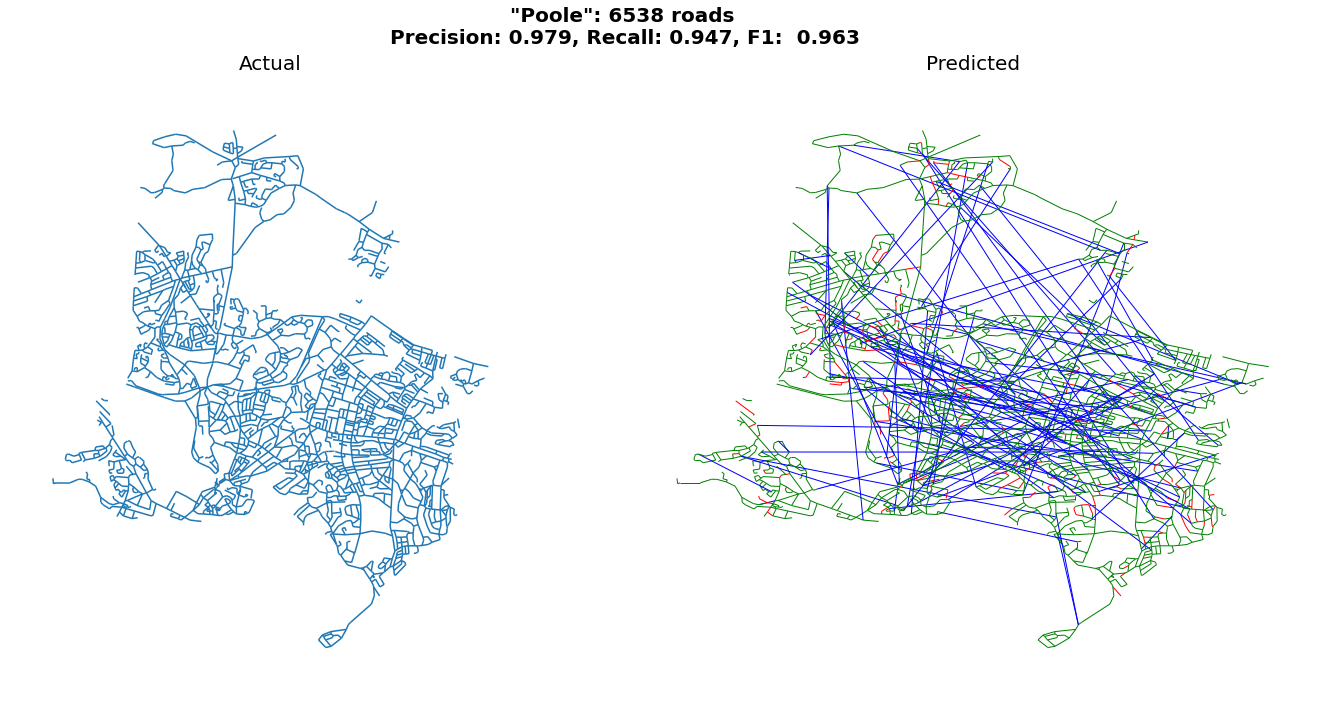

Loading Sutton from SSx
Best threshold: 0.7411
Finished prediction, rebuilding road network
Loading Sutton from SSx
Results
{'tp': 4676, 'tn': 446, 'fp': 138, 'fn': 584}


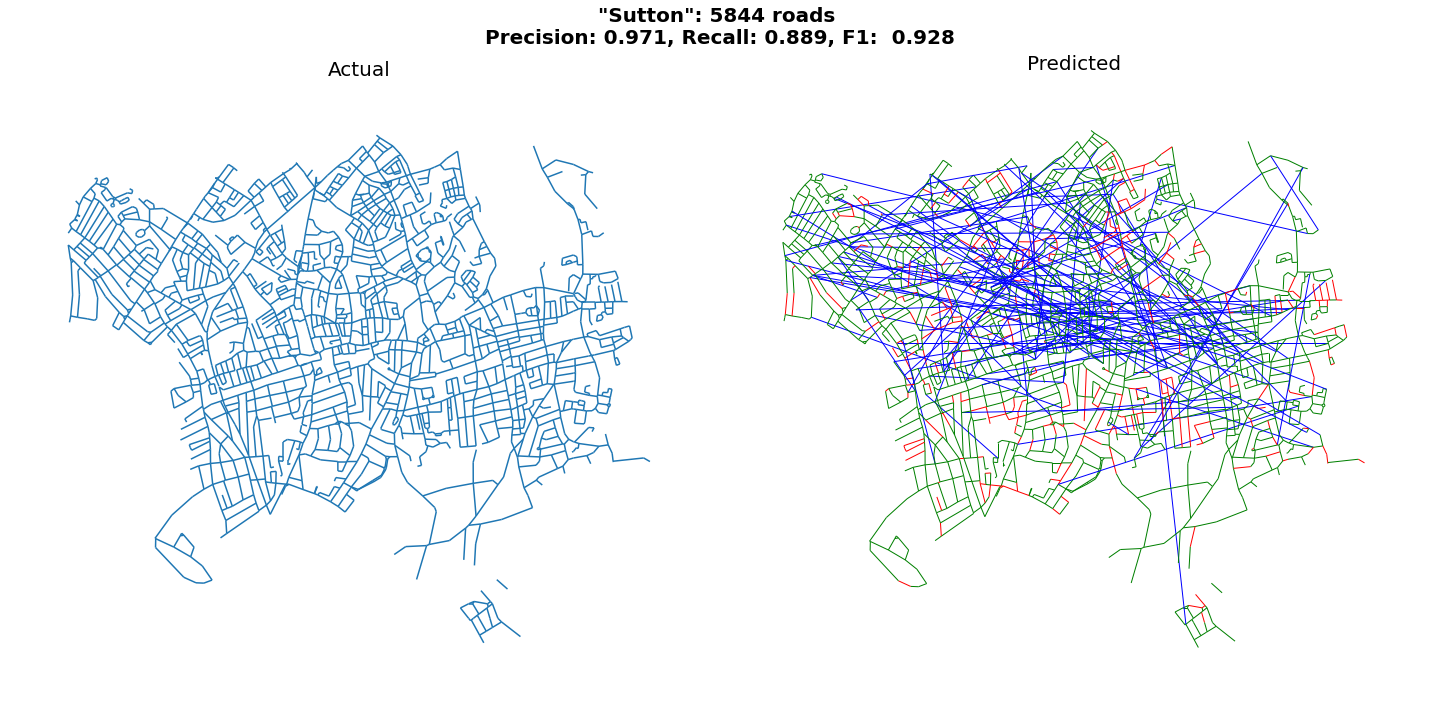

Loading Kensington and Chelsea from SSx
Best threshold: 0.8037
Finished prediction, rebuilding road network
Loading Kensington and Chelsea from SSx
Results
{'tp': 3266, 'tn': 303, 'fp': 131, 'fn': 644}


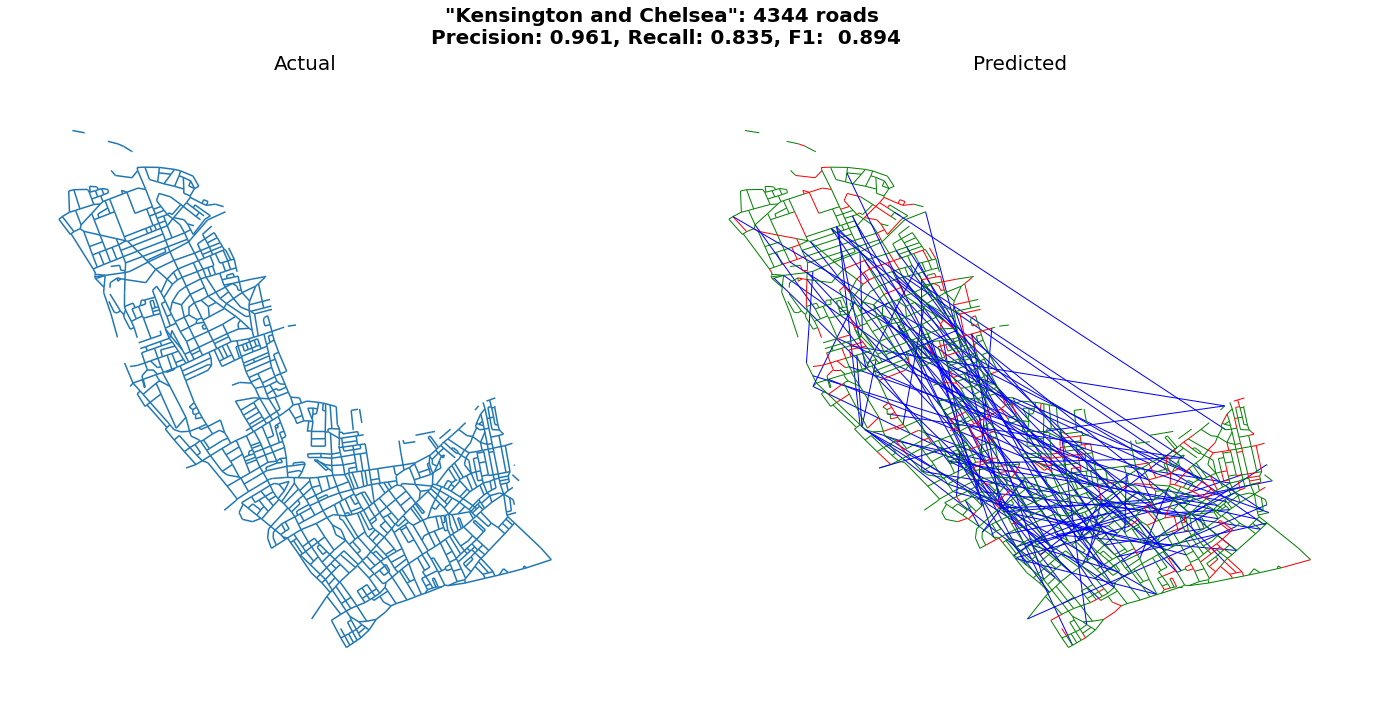

In [26]:
from torch_geometric.utils.convert import to_networkx
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve

def visualize_preds(place, model, include_feats=[], add_deg_feats=False,
                    hold_out_test_ratio=0.2, neg_sampling_ratio=1):
    original_data = load_graph(place, all_feature_fields)
    data = copy.deepcopy(original_data)

     # Remove non included features
    if len(include_feats) < len(feats):
        feat_idx = torch.tensor([feats.index(feat) for feat in include_feats])
        data.x = torch.index_select(data.x, 1, feat_idx) if len(feat_idx) > 0 else None

    # Randomly sample negative links and run predictions
    hold_out_edge_ratio = hold_out_test_ratio # Remove some edges for testing
    neg_sampling_ratio = neg_sampling_ratio # Negative-sample original edge count
    transforms = T.Compose([
        T.NormalizeFeatures(),
        T.LocalDegreeProfile() if add_deg_feats else (lambda x: x),
        T.ToDevice(device),
        T.RandomLinkSplit(num_val=0, num_test=0, disjoint_train_ratio=hold_out_edge_ratio,
                          neg_sampling_ratio=neg_sampling_ratio, is_undirected=True)
    ])
    vis_data, _, _ = transforms(data.clone())
    vis_data = vis_data.to(device)
    z = model.encode(vis_data.x, vis_data.edge_index)
    out_enc_edges = model.decode(z, vis_data.edge_index).view(-1)
    out_test_edges = model.decode(z, vis_data.edge_label_index).view(-1)
    
    out = torch.cat([out_enc_edges, out_test_edges]).cpu()
    y_label = torch.ones(vis_data.edge_index.size(1))
    edge_label = torch.cat([y_label, vis_data.edge_label.cpu()])
    
    # Calculate best threshold for edge labelling, based on geometric mean of sensitivity/specificity 
    fpr, tpr, thresholds = roc_curve(edge_label, out.detach())
    gmeans = np.sqrt(tpr * (1-fpr))
    best_threshold = thresholds[np.argmax(gmeans)]
    print(f'Best threshold: {best_threshold:.4f}')
    
    cat_index = torch.cat([vis_data.edge_index, vis_data.edge_label_index], dim=-1)
    print('Finished prediction, rebuilding road network')
    
    res_dict = {} # For storing new edge attributes in nx
    pred_dict = {} # Map of coords to predicted values
    label_dict = {} # Map of coords to labels (sanity check)
    
    gdf = load_gdf(place)
    streets = momepy.gdf_to_nx(gdf, approach='primal', multigraph=False)
    float32_node_dict = {(torch.tensor(c[0], dtype=torch.float32).item(),
                          torch.tensor(c[1], dtype=torch.float32).item()): c for c in streets}
    count_dict = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
    data = original_data
    
    # Iterate over predicted edges (which includes real and fake edges)
    for i, logit in enumerate(out):
        # Get indices of both the nodes of the edge
        u_idx, v_idx = cat_index[:, i] 
        
        # Get their coordinates (the last two node attributes in pretransformed data)
        u_float32 = data.x[u_idx, -2].item(), data.x[u_idx, -1].item()
        v_float32 = data.x[v_idx, -2].item(), data.x[v_idx, -1].item()
        # Convert them into their full precision node coordinates
        u, v = float32_node_dict[u_float32], float32_node_dict[v_float32]
        key = (u, v)
        
        label = edge_label[i]
        if (u, v) in pred_dict:
            # Should NOT happen
            raise NotImplementedError
        elif (v, u) in pred_dict:
            logit = (pred_dict[(v, u)] + logit) / 2
        else:
            pred_dict[key] = logit
        pred = 0 if logit < best_threshold else 1
        
        if not (streets.has_edge(u, v) or streets.has_edge(v, u)):
            # Negative sampled edge
            assert label == 0
            res = 'tn' if pred == label else 'fp'
            
            # Add the false positive edges for visualization
            if res == 'fp':
                streets.add_edge(u, v, res=res)
        else:
            if label != 1:
                # Abort mission
                raise NotImplementedError(u, v, label)
            res = 'tp' if pred == label else 'fn'
            res_dict[(u, v)] = res

        count_dict[res] += 1
    print('Results')
    print(count_dict)
    
    # Evaluate metrics
    tp = count_dict['tp']
    fp = count_dict['fp']
    fn = count_dict['fn']
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * prec * recall / (prec + recall)
    
    # Set attributes on the original graph
    nx.set_edge_attributes(streets, res_dict, 'res')
    
    f, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    for i, facet in enumerate(ax):
        facet.set_title(("Actual", "Predicted")[i], size=20)
        facet.axis("off")
    
    gdf.plot(ax=ax[0])
    # lines = momepy.nx_to_gdf(gdf, approach='primal', multigraph=False)
    color_state_map = {'tp': 'green', 'fp': 'blue', 'fn': 'red'}
    colors = [color_state_map[edge[2]['res']] for edge in streets.edges(data=True)]
    nx.draw(streets, {n:[n[0], n[1]] for n in list(streets.nodes)}, node_size=0, edge_color=colors,
            edge_cmap='Set1', ax=ax[1])
    plt.suptitle(f'\"{place}\": {data.num_edges} roads\n Precision: {prec:.3f}, Recall: {recall:.3f}, F1: {f1: .3f}',
                fontweight="bold", fontsize=20)
    plt.tight_layout()
    plt.show()

     # plot original and predicted streets
    # f, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    # for i, facet in enumerate(ax):
    #     facet.set_title(("Original", "Predicted")[i], size=20)
    #     facet.axis("off")
    # lines.plot(ax=ax[0], column=f'choice{rad}{mod}', cmap='jet',
    #            legend=True, legend_kwds={'shrink': 0.3})
    # lines.plot(ax=ax[1], column='preds', cmap='jet', legend=True,
    #            legend_kwds={'shrink': 0.3})
    # plt.suptitle(f'\"{place}\": choice{rad}{mod}\n {graph.num_nodes} road nodes. R2: {r2:.3f}, KT: {kt:.3f}',
    #              fontweight="bold", fontsize=20)
    # plt.tight_layout()
    # plt.show()

loaded_graphs = {}
test_places = ['Poole', 'Sutton', 'Kensington and Chelsea']
model = init_model(False, False, 4, 5)
model.load_state_dict(torch.load('./models/GAE_5d_1000epochs_0.01lr_4feats.pt'))
model = model.eval().to(device)
for place in test_places:
    visualize_preds(place, model, include_feats=rank_fields, add_deg_feats=False)

# Standard GAE-GCN Link Pred

In [ ]:
from torch_geometric.utils import negative_sampling

transform = RandomLinkSplit(num_val=0.05, num_test=0.1,
                            is_undirected=True, add_negative_train_samples=False)
train_data, val_data, test_data = transform(data)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(data.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
print_every = 10
epochs = 1000
for epoch in range(1, epochs + 1):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
              f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

# ARGVA

In [37]:
from torch_geometric.nn import Linear, ARGVA, GCNConv


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = self.lin1(x).relu()
        x = self.lin2(x).relu()
        return self.lin3(x)

in_channels = dataset[0].num_node_features
encoder = Encoder(in_channels, hidden_channels=32, out_channels=32)
discriminator = Discriminator(in_channels=32, hidden_channels=64,
                              out_channels=32)
model = ARGVA(encoder, discriminator).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                                           lr=0.001)


def train(loader):
    model.train()
    encoder_optimizer.zero_grad()
    loss_tot = 0
    for data in loader:
        z = model.encode(data.x, data.edge_index)

        # We optimize the discriminator more frequently than the encoder.
        for i in range(5):
            discriminator_optimizer.zero_grad()
            discriminator_loss = model.discriminator_loss(z)
            discriminator_loss.backward()
            discriminator_optimizer.step()

        loss = model.recon_loss(z, data.edge_index)
        loss = loss + model.reg_loss(z)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        encoder_optimizer.step()
        loss_tot += loss
    loss_tot /= len(loader)
    return float(loss_tot)


@torch.no_grad()
def test(dataset):
    model.eval()
    auc_tot = 0
    ap_tot = 0
    for data in dataset:
        z = model.encode(data.x, data.edge_index)
        auc, ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
        auc_tot += auc
        ap_tot += ap
    return auc_tot / len(dataset), ap_tot / len(dataset)

for epoch in range(1, 1001):
    loss = train(train_loader)
    auc, ap = test(test_dataset)
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}'))


Epoch: 001, Loss: 81019748352.000, AUC: 0.500, AP: 0.500
Epoch: 002, Loss: 20473374720.000, AUC: 0.500, AP: 0.500
Epoch: 003, Loss: 12014949376.000, AUC: 0.500, AP: 0.500
Epoch: 004, Loss: 8888396800.000, AUC: 0.500, AP: 0.500
Epoch: 005, Loss: 4453917696.000, AUC: 0.512, AP: 0.506
Epoch: 006, Loss: 3177200128.000, AUC: 0.534, AP: 0.518
Epoch: 007, Loss: 2366480384.000, AUC: 0.618, AP: 0.567
Epoch: 008, Loss: 673854144.000, AUC: 0.570, AP: 0.539
Epoch: 009, Loss: 909244608.000, AUC: 0.585, AP: 0.548
Epoch: 010, Loss: 449847424.000, AUC: 0.563, AP: 0.534
Epoch: 011, Loss: 559399296.000, AUC: 0.618, AP: 0.568
Epoch: 012, Loss: 308360128.000, AUC: 0.623, AP: 0.571
Epoch: 013, Loss: 331327968.000, AUC: 0.630, AP: 0.576
Epoch: 014, Loss: 144368160.000, AUC: 0.649, AP: 0.589
Epoch: 015, Loss: 265160560.000, AUC: 0.652, AP: 0.591
Epoch: 016, Loss: 147944048.000, AUC: 0.639, AP: 0.582
Epoch: 017, Loss: 237610608.000, AUC: 0.651, AP: 0.590
Epoch: 018, Loss: 199703008.000, AUC: 0.645, AP: 0.586


# SEAL + DGCNN

In [14]:
class SEALDataset(InMemoryDataset):
    def __init__(self, dataset, num_hops, split='train'):
        self.data = dataset[0]
        self.num_hops = num_hops
        super().__init__(dataset_root)
        index = ['train', 'val', 'test'].index(split)
        self.data, self.slices = torch.load(self.processed_paths[index])

    @property
    def processed_file_names(self):
        return ['SEAL_train_data.pt', 'SEAL_val_data.pt', 'SEAL_test_data.pt']

    def process(self):
        transform = RandomLinkSplit(num_val=0.05, num_test=0.1,
                                    is_undirected=True, split_labels=True)
        train_data, val_data, test_data = transform(self.data)

        self._max_z = 0

        # Collect a list of subgraphs for training, validation and testing:
        train_pos_data_list = self.extract_enclosing_subgraphs(
            train_data.edge_index, train_data.pos_edge_label_index, 1)
        train_neg_data_list = self.extract_enclosing_subgraphs(
            train_data.edge_index, train_data.neg_edge_label_index, 0)

        val_pos_data_list = self.extract_enclosing_subgraphs(
            val_data.edge_index, val_data.pos_edge_label_index, 1)
        val_neg_data_list = self.extract_enclosing_subgraphs(
            val_data.edge_index, val_data.neg_edge_label_index, 0)

        test_pos_data_list = self.extract_enclosing_subgraphs(
            test_data.edge_index, test_data.pos_edge_label_index, 1)
        test_neg_data_list = self.extract_enclosing_subgraphs(
            test_data.edge_index, test_data.neg_edge_label_index, 0)

        # Convert node labeling to one-hot features.
        for data in chain(train_pos_data_list, train_neg_data_list,
                          val_pos_data_list, val_neg_data_list,
                          test_pos_data_list, test_neg_data_list):
            # We solely learn links from structure, dropping any node features:
            data.x = F.one_hot(data.z, self._max_z + 1).to(torch.float)

        torch.save(self.collate(train_pos_data_list + train_neg_data_list),
                   self.processed_paths[0])
        torch.save(self.collate(val_pos_data_list + val_neg_data_list),
                   self.processed_paths[1])
        torch.save(self.collate(test_pos_data_list + test_neg_data_list),
                   self.processed_paths[2])

    def extract_enclosing_subgraphs(self, edge_index, edge_label_index, y):
        data_list = []
        for src, dst in edge_label_index.t().tolist():
            sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
                [src, dst], self.num_hops, edge_index, relabel_nodes=True)
            src, dst = mapping.tolist()

            # Remove target link from the subgraph.
            mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
            mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
            sub_edge_index = sub_edge_index[:, mask1 & mask2]

            # Calculate node labeling.
            z = self.drnl_node_labeling(sub_edge_index, src, dst,
                                        num_nodes=sub_nodes.size(0))

            data = Data(x=self.data.x[sub_nodes], z=z,
                        edge_index=sub_edge_index, y=y)
            data_list.append(data)

        return data_list

    def drnl_node_labeling(self, edge_index, src, dst, num_nodes=None):
        # Double-radius node labeling (DRNL).
        src, dst = (dst, src) if src > dst else (src, dst)
        adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).tocsr()

        idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
        adj_wo_src = adj[idx, :][:, idx]

        idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
        adj_wo_dst = adj[idx, :][:, idx]

        dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True,
                                 indices=src)
        dist2src = np.insert(dist2src, dst, 0, axis=0)
        dist2src = torch.from_numpy(dist2src)

        dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True,
                                 indices=dst - 1)
        dist2dst = np.insert(dist2dst, src, 0, axis=0)
        dist2dst = torch.from_numpy(dist2dst)

        dist = dist2src + dist2dst
        dist_over_2, dist_mod_2 = dist // 2, dist % 2

        z = 1 + torch.min(dist2src, dist2dst)
        z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
        z[src] = 1.
        z[dst] = 1.
        z[torch.isnan(z)] = 0.

        self._max_z = max(int(z.max()), self._max_z)

        return z.to(torch.long)

dataset = [data]

train_dataset = SEALDataset(dataset, num_hops=2, split='train')
val_dataset = SEALDataset(dataset, num_hops=2, split='val')
test_dataset = SEALDataset(dataset, num_hops=2, split='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


Processing...
/tmp/ipykernel_2883187/1265208625.py:94: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dist_over_2, dist_mod_2 = dist // 2, dist % 2
Done!


In [15]:
class DGCNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, GNN=GCNConv, k=0.6):
        super().__init__()

        if k < 1:  # Transform percentile to number.
            num_nodes = sorted([data.num_nodes for data in train_dataset])
            k = num_nodes[int(math.ceil(k * len(num_nodes))) - 1]
            k = max(10, k)
        self.k = int(k)

        self.convs = ModuleList()
        self.convs.append(GNN(train_dataset.num_features, hidden_channels))
        for i in range(0, num_layers - 1):
            self.convs.append(GNN(hidden_channels, hidden_channels))
        self.convs.append(GNN(hidden_channels, 1))

        conv1d_channels = [16, 32]
        total_latent_dim = hidden_channels * num_layers + 1
        conv1d_kws = [total_latent_dim, 5]
        self.conv1 = Conv1d(1, conv1d_channels[0], conv1d_kws[0],
                            conv1d_kws[0])
        self.maxpool1d = MaxPool1d(2, 2)
        self.conv2 = Conv1d(conv1d_channels[0], conv1d_channels[1],
                            conv1d_kws[1], 1)
        dense_dim = int((self.k - 2) / 2 + 1)
        dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        self.mlp = MLP([dense_dim, 128, 1], dropout=0.5, batch_norm=False)

    def forward(self, x, edge_index, batch):
        xs = [x]
        for conv in self.convs:
            xs += [conv(xs[-1], edge_index).tanh()]
        x = torch.cat(xs[1:], dim=-1)

        # Global pooling.
        x = global_sort_pool(x, batch, self.k)
        x = x.unsqueeze(1)  # [num_graphs, 1, k * hidden]
        x = self.conv1(x).relu()
        x = self.maxpool1d(x)
        x = self.conv2(x).relu()
        x = x.view(x.size(0), -1)  # [num_graphs, dense_dim]

        return self.mlp(x)

In [16]:
model = DGCNN(hidden_channels=32, num_layers=3).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = BCEWithLogitsLoss()


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.to(torch.float))
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    y_pred, y_true = [], []
    for data in loader:
        data = data.to(device)
        logits = model(data.x, data.edge_index, data.batch)
        y_pred.append(logits.view(-1).cpu())
        y_true.append(data.y.view(-1).cpu().to(torch.float))

    return roc_auc_score(torch.cat(y_true), torch.cat(y_pred))


best_val_auc = test_auc = 0
for epoch in range(1, 51):
    loss = train()
    val_auc = test(val_loader)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        test_auc = test(test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

Epoch: 01, Loss: 0.5439, Val: 0.8484, Test: 0.8939
Epoch: 02, Loss: 0.4729, Val: 0.8508, Test: 0.8964
Epoch: 03, Loss: 0.4682, Val: 0.8532, Test: 0.8993
Epoch: 04, Loss: 0.4654, Val: 0.8562, Test: 0.9029
Epoch: 05, Loss: 0.4600, Val: 0.8595, Test: 0.9057
Epoch: 06, Loss: 0.4584, Val: 0.8601, Test: 0.9067
Epoch: 07, Loss: 0.4546, Val: 0.8630, Test: 0.9085
Epoch: 08, Loss: 0.4515, Val: 0.8620, Test: 0.9085
Epoch: 09, Loss: 0.4477, Val: 0.8633, Test: 0.9105
Epoch: 10, Loss: 0.4458, Val: 0.8654, Test: 0.9116
Epoch: 11, Loss: 0.4447, Val: 0.8671, Test: 0.9119
Epoch: 12, Loss: 0.4444, Val: 0.8678, Test: 0.9132
Epoch: 13, Loss: 0.4419, Val: 0.8682, Test: 0.9140
Epoch: 14, Loss: 0.4423, Val: 0.8671, Test: 0.9140
Epoch: 15, Loss: 0.4401, Val: 0.8672, Test: 0.9140
Epoch: 16, Loss: 0.4406, Val: 0.8668, Test: 0.9140
Epoch: 17, Loss: 0.4395, Val: 0.8675, Test: 0.9140
Epoch: 18, Loss: 0.4396, Val: 0.8679, Test: 0.9140
Epoch: 19, Loss: 0.4388, Val: 0.8673, Test: 0.9140
Epoch: 20, Loss: 0.4380, Val: 0

# RGCN

In [ ]:
from torch.nn import Parameter
from torch_geometric.nn import GAE, RGCNConv

class RGCNEncoder(torch.nn.Module):
    def __init__(self, num_nodes, hidden_channels, num_relations):
        super().__init__()
        self.node_emb = Parameter(torch.Tensor(num_nodes, hidden_channels))
        self.conv1 = RGCNConv(hidden_channels, hidden_channels, num_relations,
                              num_blocks=5)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations,
                              num_blocks=5)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.node_emb)
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, edge_index, edge_type):
        x = self.node_emb
        x = self.conv1(x, edge_index, edge_type).relu_()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        return x


class DistMultDecoder(torch.nn.Module):
    def __init__(self, num_relations, hidden_channels):
        super().__init__()
        self.rel_emb = Parameter(torch.Tensor(num_relations, hidden_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.rel_emb)

    def forward(self, z, edge_index, edge_type):
        z_src, z_dst = z[edge_index[0]], z[edge_index[1]]
        rel = self.rel_emb[edge_type]
        return torch.sum(z_src * rel * z_dst, dim=1)


model = GAE(
    RGCNEncoder(data.num_nodes, hidden_channels=500,
                num_relations=dataset.num_relations),
    DistMultDecoder(dataset.num_relations // 2, hidden_channels=500),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def negative_sampling(edge_index, num_nodes):
    # Sample edges by corrupting either the subject or the object of each edge.
    mask_1 = torch.rand(edge_index.size(1)) < 0.5
    mask_2 = ~mask_1

    neg_edge_index = edge_index.clone()
    neg_edge_index[0, mask_1] = torch.randint(num_nodes, (mask_1.sum(), ))
    neg_edge_index[1, mask_2] = torch.randint(num_nodes, (mask_2.sum(), ))
    return neg_edge_index


def train():
    model.train()
    optimizer.zero_grad()

    z = model.encode(data.edge_index, data.edge_type)

    pos_out = model.decode(z, data.train_edge_index, data.train_edge_type)

    neg_edge_index = negative_sampling(data.train_edge_index, data.num_nodes)
    neg_out = model.decode(z, neg_edge_index, data.train_edge_type)

    out = torch.cat([pos_out, neg_out])
    gt = torch.cat([torch.ones_like(pos_out), torch.zeros_like(neg_out)])
    cross_entropy_loss = F.binary_cross_entropy_with_logits(out, gt)
    reg_loss = z.pow(2).mean() + model.decoder.rel_emb.pow(2).mean()
    loss = cross_entropy_loss + 1e-2 * reg_loss

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.edge_index, data.edge_type)

    valid_mrr = compute_mrr(z, data.valid_edge_index, data.valid_edge_type)
    test_mrr = compute_mrr(z, data.test_edge_index, data.test_edge_type)

    return valid_mrr, test_mrr


@torch.no_grad()
def compute_mrr(z, edge_index, edge_type):
    ranks = []
    for i in tqdm(range(edge_type.numel())):
        (src, dst), rel = edge_index[:, i], edge_type[i]

        # Try all nodes as tails, but delete true triplets:
        tail_mask = torch.ones(data.num_nodes, dtype=torch.bool)
        for (heads, tails), types in [
            (data.train_edge_index, data.train_edge_type),
            (data.valid_edge_index, data.valid_edge_type),
            (data.test_edge_index, data.test_edge_type),
        ]:
            tail_mask[tails[(heads == src) & (types == rel)]] = False

        tail = torch.arange(data.num_nodes)[tail_mask]
        tail = torch.cat([torch.tensor([dst]), tail])
        head = torch.full_like(tail, fill_value=src)
        eval_edge_index = torch.stack([head, tail], dim=0)
        eval_edge_type = torch.full_like(tail, fill_value=rel)

        out = model.decode(z, eval_edge_index, eval_edge_type)
        perm = out.argsort(descending=True)
        rank = int((perm == 0).nonzero(as_tuple=False).view(-1)[0])
        ranks.append(rank + 1)

        # Try all nodes as heads, but delete true triplets:
        head_mask = torch.ones(data.num_nodes, dtype=torch.bool)
        for (heads, tails), types in [
            (data.train_edge_index, data.train_edge_type),
            (data.valid_edge_index, data.valid_edge_type),
            (data.test_edge_index, data.test_edge_type),
        ]:
            head_mask[heads[(tails == dst) & (types == rel)]] = False

        head = torch.arange(data.num_nodes)[head_mask]
        head = torch.cat([torch.tensor([src]), head])
        tail = torch.full_like(head, fill_value=dst)
        eval_edge_index = torch.stack([head, tail], dim=0)
        eval_edge_type = torch.full_like(head, fill_value=rel)

        out = model.decode(z, eval_edge_index, eval_edge_type)
        perm = out.argsort(descending=True)
        rank = int((perm == 0).nonzero(as_tuple=False).view(-1)[0])
        ranks.append(rank + 1)

    return (1. / torch.tensor(ranks, dtype=torch.float)).mean()


for epoch in range(1, 10001):
    loss = train()
    print(f'Epoch: {epoch:05d}, Loss: {loss:.4f}')
    if (epoch % 500) == 0:
        valid_mrr, test_mrr = test()
        print(f'Val MRR: {valid_mrr:.4f}, Test MRR: {test_mrr:.4f}')